## **LIBRARIES IMPORTED AND SETUP**

In [1]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import random
import seaborn as sns
%matplotlib inline

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) 

# Setup device (gpu or cpu)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  Tesla T4


## **DATASET LOADER**

In [2]:
def get_transforms(size, normalize, split):
    """
    Get data transforms for CIFAR100

    Args:
        size: Image size ('32' or '224')
        normalize: Normalization type ('standard' or 'imagenet')
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
    Returns:
        torchvision.transforms.Compose object
    """
    if normalize == "imagenet":
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == "standard":
        mean = [0.5071, 0.4865, 0.4409]
        std = [0.2673, 0.2564, 0.2762]
    transform_list = []
    # Add data augmentation for training
    if split == "train":
        if size == "224":
            train_transform = transform_list.extend(
                [
                    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
                ]
            )
        elif size == "32":
            train_transform = transform_list.extend(
                [
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(15),
                ]
            )
    elif split == "test":
        if size == "224":
            test_transform = transform_list.extend(
                [
                    transforms.Resize((224, 224)),
                ]
            )

    # Add basic transforms
    transform_list.extend([transforms.ToTensor(), transforms.Normalize(mean, std)])

    return transforms.Compose(transform_list)

In [3]:
def worker_init_fn(worker_id):
    np.random.seed(SEED + worker_id)
    random.seed(SEED + worker_id)
    torch.manual_seed(SEED + worker_id)

In [4]:
def CIFAR100DataLoader_v2(
    split,
    batch_size=8,
    num_workers=2,
    shuffle=True,
    size="32",
    normalize="standard",
    seed=42,
):
    """
    A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')

    Output:
        DataLoader Object
    """

    # Get appropriate transforms
    transforms = get_transforms(size, normalize, split)
    if split == "train":
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=True, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )
    else:
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=False, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )

## **VIT MODEL SETUP**

In [5]:
# Attention layer
class Attention(nn.Module):
    """
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        _reshape_heads(inp) :-
        Changes the input sequence embeddings to reduced dimension according to the number
        of attention heads to parallelize attention operation
        (batch_size, seq_len, embed_dim) -> (batch_size * heads, seq_len, reduced_dim)

        _reshape_heads_back(inp) :-
        Changes the reduced dimension due to parallel attention heads back to the original
        embedding size
        (batch_size * heads, seq_len, reduced_dim) -> (batch_size, seq_len, embed_dim)

        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention as well as atttention scores
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim), (batch_size * heads, seq_len, seq_len)

    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out, weights = attention(inp)
    """

    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == "relu":
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key = self.activation(self.key(inp))
        value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) |
        # reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key = self._reshape_heads(key)
        value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) |
        # Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), value)

        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out


# Feed Forward layer
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    """
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> FF = FeedForward(8, 1)
        >>> out = FF(inp)
    """

    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out


# Encoder block
class TransformerBlock(nn.Module):
    """
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-

    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> TB = TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout)
        >>> out = TB(inp)
    """

    def __init__(
        self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1
    ):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res

        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out


# Encoder block with multi layer
class Transformer(nn.Module):
    """
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    """

    def __init__(
        self,
        embed_dim,
        layers,
        heads=8,
        activation=None,
        forward_expansion=1,
        dropout=0.1,
    ):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim, heads, activation, forward_expansion, dropout
                )
                for i in range(layers)
            ]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out


# MLP Head
class ClassificationHead(nn.Module):
    """
    Classification Head attached to the first sequence token which is used as the arbitrary
    classification token and used to optimize the transformer model by applying Cross-Entropy
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)

    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    """

    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes)
        return out


class VisionTransformer(nn.Module):
    """
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|

    Args:
        patch_size: Length of square patch size
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of the transformer
        (batch_size, channels, width, height) -> (batch_size, classes), (batch_size, seq_len+1, embed_dim)

    Examples:
        >>> ViT = VisionTransformer(atch_size, max_len, embed_dim, classes, layers, channels, heads, activation, forward_expansion, dropout)
        >>> class_out, hidden_seq = ViT(inp)
    """

    def __init__(
        self,
        patch_size,
        max_len,
        embed_dim,
        classes,
        layers,
        channels=3,
        heads=8,
        activation=None,
        forward_expansion=1,
        dropout=0.1,
    ):
        super(VisionTransformer, self).__init__()
        self.name = "VisionTransformer"
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(
            embed_dim, layers, heads, activation, forward_expansion, dropout
        )
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        # Split image into small patch
        out = (
            inp.unfold(2, self.patch_size, self.patch_size)
            .unfold(3, self.patch_size, self.patch_size)
            .contiguous()
        )
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) |
        # seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()

        # Flatten patch into 1 dimension
        out = out.reshape(batch_size, seq_len, -1)
        # Mapping from patch 1 dimension to hidden embedding dimension
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        # Add class token to head of embedding vector
        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[: seq_len + 1]
        position_embed = position_embed.unsqueeze(0).expand(
            batch_size, seq_len + 1, self.embed_dim
        )
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim)
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)

        return class_out, out

## **TRAINING, EVALUATION AND TESTING FUNCTION**

In [6]:
# Training model
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):
    """
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model
        scheduler: Scheduler used to update the learing rate for faster convergence
                   (Commented out due to poor results)
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    """
    running_loss = 0.0
    running_accuracy = 0.0

    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)

        if model.name == "VisionTransformer":
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == "ResNet":
            output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy


# Validation model
def evaluation(model, dataloader, criterion, resnet_features=None):
    """
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    """
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy


def test(model, dataloader, resnet_features=None):
    """
    Function used to test the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        all_preds: All model predict label (Int)
        all_labels: All dataset label (Int)
    """
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for data, label in tqdm(dataloader):
            data = data.to(device)
            target = label.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)

            pred = output.argmax(dim=1)
            all_preds.extend(pred)
            all_labels.extend(label)

    return all_preds, all_labels

## **INITIALIZE VARIABLE**

In [7]:
max_len = 100  # All sequences must be less than 1000 including class token
classes = 100
image_sz = 32
channels = 3

lr = 0.001
epochs = 100

patch_size = 16
batch_size = 32
num_workers = 2
shuffle = True

embed_dim = 768

layers = 8
heads = 12

resnet_features_channels = 64

In [8]:
# Init model
model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads,
).to(device)

resnet_features = None

## **TRAINING AND TEST**

In [9]:
# Init data loader
train_dataloader = CIFAR100DataLoader_v2(
    split="train",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=shuffle,
    size="32",
    normalize="standard",
)
test_dataloader = CIFAR100DataLoader_v2(
    split="test",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    size="32",
    normalize="standard",
)

100%|██████████| 169001437/169001437 [00:02<00:00, 71466823.52it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
# Initialize first time training
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs
)

train_accs = []
test_accs = []
last_epoch = 0

In [11]:
# Record the start time
start_time = time.time()
# Running
for epoch in range(epochs - last_epoch):
    epoch += last_epoch
    running_loss, running_accuracy = train(
        model, train_dataloader, criterion, optimizer, scheduler, resnet_features
    )
    print(
        f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n"
    )
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(
        model, test_dataloader, criterion, resnet_features
    )
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch + 1) % 5 == 0:
        torch.save(
            {
                "epoch": epoch,
                "model": model,
                "optimizer": optimizer,
                "scheduler": scheduler,
                "train_acc": train_accs,
                "test_acc": test_accs,
            },
            model.name + "_patch16-768d-12h-8l_CIFAR100_checkpoint_" + str(epoch) + ".pt",
        )

torch.save(
    {
        "epoch": epoch,
        "model": model,
        "optimizer": optimizer,
        "scheduler": scheduler,
        "train_acc": train_accs,
        "test_acc": test_accs,
    },
    model.name + "_patch16-768d-12h-8l_CIFAR100.pt",
)

# Record the end time
end_time = time.time()
# Calculate the time difference
time_difference = end_time - start_time

print(f"Start Time: {start_time}")
print(f"End Time: {end_time}")
print(f"Time Taken: {time_difference} seconds")

100%|██████████| 1563/1563 [00:46<00:00, 33.32it/s]


Epoch : 1 - acc: 0.0724 - loss : 4.1412



100%|██████████| 313/313 [00:03<00:00, 103.53it/s]


test acc: 0.1073 - test loss : 3.8831



100%|██████████| 1563/1563 [00:46<00:00, 33.50it/s]


Epoch : 2 - acc: 0.1140 - loss : 3.8213



100%|██████████| 313/313 [00:02<00:00, 104.75it/s]


test acc: 0.1393 - test loss : 3.6946



100%|██████████| 1563/1563 [00:46<00:00, 33.79it/s]


Epoch : 3 - acc: 0.1363 - loss : 3.6788



100%|██████████| 313/313 [00:02<00:00, 106.54it/s]


test acc: 0.1585 - test loss : 3.5766



100%|██████████| 1563/1563 [00:46<00:00, 33.82it/s]


Epoch : 4 - acc: 0.1524 - loss : 3.5817



100%|██████████| 313/313 [00:03<00:00, 97.34it/s] 


test acc: 0.1735 - test loss : 3.4894



100%|██████████| 1563/1563 [00:46<00:00, 33.52it/s]


Epoch : 5 - acc: 0.1694 - loss : 3.4950



100%|██████████| 313/313 [00:03<00:00, 101.01it/s]


test acc: 0.1882 - test loss : 3.4104



100%|██████████| 1563/1563 [00:46<00:00, 33.26it/s]


Epoch : 6 - acc: 0.1810 - loss : 3.4222



100%|██████████| 313/313 [00:02<00:00, 107.19it/s]


test acc: 0.1947 - test loss : 3.3722



100%|██████████| 1563/1563 [00:46<00:00, 33.73it/s]


Epoch : 7 - acc: 0.1937 - loss : 3.3574



100%|██████████| 313/313 [00:02<00:00, 104.76it/s]


test acc: 0.2117 - test loss : 3.2939



100%|██████████| 1563/1563 [00:46<00:00, 33.46it/s]


Epoch : 8 - acc: 0.2033 - loss : 3.3036



100%|██████████| 313/313 [00:02<00:00, 104.99it/s]


test acc: 0.2080 - test loss : 3.2897



100%|██████████| 1563/1563 [00:46<00:00, 33.86it/s]


Epoch : 9 - acc: 0.2080 - loss : 3.2545



100%|██████████| 313/313 [00:02<00:00, 107.86it/s]


test acc: 0.2162 - test loss : 3.2652



100%|██████████| 1563/1563 [00:46<00:00, 33.75it/s]


Epoch : 10 - acc: 0.2168 - loss : 3.2094



100%|██████████| 313/313 [00:03<00:00, 101.88it/s]


test acc: 0.2209 - test loss : 3.2074



100%|██████████| 1563/1563 [00:46<00:00, 33.46it/s]


Epoch : 11 - acc: 0.2244 - loss : 3.1681



100%|██████████| 313/313 [00:03<00:00, 101.14it/s]


test acc: 0.2284 - test loss : 3.1682



100%|██████████| 1563/1563 [00:46<00:00, 33.75it/s]


Epoch : 12 - acc: 0.2318 - loss : 3.1291



100%|██████████| 313/313 [00:02<00:00, 105.64it/s]


test acc: 0.2367 - test loss : 3.1606



100%|██████████| 1563/1563 [00:46<00:00, 33.57it/s]


Epoch : 13 - acc: 0.2377 - loss : 3.0880



100%|██████████| 313/313 [00:03<00:00, 104.04it/s]


test acc: 0.2457 - test loss : 3.1111



100%|██████████| 1563/1563 [00:46<00:00, 33.39it/s]


Epoch : 14 - acc: 0.2432 - loss : 3.0630



100%|██████████| 313/313 [00:02<00:00, 106.34it/s]


test acc: 0.2454 - test loss : 3.0998



100%|██████████| 1563/1563 [00:46<00:00, 33.71it/s]


Epoch : 15 - acc: 0.2507 - loss : 3.0296



100%|██████████| 313/313 [00:02<00:00, 106.80it/s]


test acc: 0.2505 - test loss : 3.0790



100%|██████████| 1563/1563 [00:46<00:00, 33.45it/s]


Epoch : 16 - acc: 0.2557 - loss : 2.9983



100%|██████████| 313/313 [00:02<00:00, 105.40it/s]


test acc: 0.2579 - test loss : 3.0537



100%|██████████| 1563/1563 [00:46<00:00, 33.75it/s]


Epoch : 17 - acc: 0.2618 - loss : 2.9620



100%|██████████| 313/313 [00:02<00:00, 107.80it/s]


test acc: 0.2552 - test loss : 3.0600



100%|██████████| 1563/1563 [00:46<00:00, 33.66it/s]


Epoch : 18 - acc: 0.2641 - loss : 2.9428



100%|██████████| 313/313 [00:02<00:00, 107.79it/s]


test acc: 0.2635 - test loss : 3.0484



100%|██████████| 1563/1563 [00:46<00:00, 33.90it/s]


Epoch : 19 - acc: 0.2716 - loss : 2.9054



100%|██████████| 313/313 [00:03<00:00, 102.83it/s]


test acc: 0.2652 - test loss : 3.0093



100%|██████████| 1563/1563 [00:45<00:00, 34.51it/s]


Epoch : 20 - acc: 0.2797 - loss : 2.8764



100%|██████████| 313/313 [00:03<00:00, 104.01it/s]


test acc: 0.2714 - test loss : 3.0047



100%|██████████| 1563/1563 [00:46<00:00, 33.47it/s]


Epoch : 21 - acc: 0.2828 - loss : 2.8524



100%|██████████| 313/313 [00:02<00:00, 104.92it/s]


test acc: 0.2739 - test loss : 2.9908



100%|██████████| 1563/1563 [00:46<00:00, 33.75it/s]


Epoch : 22 - acc: 0.2869 - loss : 2.8330



100%|██████████| 313/313 [00:03<00:00, 103.63it/s]


test acc: 0.2722 - test loss : 2.9816



100%|██████████| 1563/1563 [00:47<00:00, 33.17it/s]


Epoch : 23 - acc: 0.2920 - loss : 2.8035



100%|██████████| 313/313 [00:03<00:00, 103.68it/s]


test acc: 0.2790 - test loss : 2.9841



100%|██████████| 1563/1563 [00:47<00:00, 33.14it/s]


Epoch : 24 - acc: 0.2988 - loss : 2.7844



100%|██████████| 313/313 [00:02<00:00, 109.45it/s]


test acc: 0.2821 - test loss : 2.9563



100%|██████████| 1563/1563 [00:46<00:00, 33.69it/s]


Epoch : 25 - acc: 0.3018 - loss : 2.7537



100%|██████████| 313/313 [00:02<00:00, 106.12it/s]


test acc: 0.2834 - test loss : 2.9414



100%|██████████| 1563/1563 [00:46<00:00, 33.35it/s]


Epoch : 26 - acc: 0.3069 - loss : 2.7310



100%|██████████| 313/313 [00:02<00:00, 112.33it/s]


test acc: 0.2877 - test loss : 2.9383



100%|██████████| 1563/1563 [00:46<00:00, 33.56it/s]


Epoch : 27 - acc: 0.3091 - loss : 2.7061



100%|██████████| 313/313 [00:02<00:00, 107.51it/s]


test acc: 0.2937 - test loss : 2.9382



100%|██████████| 1563/1563 [00:46<00:00, 33.33it/s]


Epoch : 28 - acc: 0.3129 - loss : 2.6932



100%|██████████| 313/313 [00:03<00:00, 102.46it/s]


test acc: 0.2854 - test loss : 2.9281



100%|██████████| 1563/1563 [00:46<00:00, 33.31it/s]


Epoch : 29 - acc: 0.3182 - loss : 2.6639



100%|██████████| 313/313 [00:03<00:00, 97.94it/s] 


test acc: 0.2929 - test loss : 2.9305



100%|██████████| 1563/1563 [00:45<00:00, 34.10it/s]


Epoch : 30 - acc: 0.3214 - loss : 2.6376



100%|██████████| 313/313 [00:02<00:00, 106.42it/s]


test acc: 0.2883 - test loss : 2.9272



100%|██████████| 1563/1563 [00:46<00:00, 33.70it/s]


Epoch : 31 - acc: 0.3281 - loss : 2.6219



100%|██████████| 313/313 [00:02<00:00, 105.11it/s]


test acc: 0.2961 - test loss : 2.9013



100%|██████████| 1563/1563 [00:47<00:00, 33.10it/s]


Epoch : 32 - acc: 0.3327 - loss : 2.5908



100%|██████████| 313/313 [00:03<00:00, 99.28it/s] 


test acc: 0.2884 - test loss : 2.9188



100%|██████████| 1563/1563 [00:47<00:00, 33.16it/s]


Epoch : 33 - acc: 0.3383 - loss : 2.5738



100%|██████████| 313/313 [00:02<00:00, 107.95it/s]


test acc: 0.2928 - test loss : 2.9227



100%|██████████| 1563/1563 [00:45<00:00, 34.26it/s]


Epoch : 34 - acc: 0.3414 - loss : 2.5571



100%|██████████| 313/313 [00:02<00:00, 105.40it/s]


test acc: 0.2973 - test loss : 2.9068



100%|██████████| 1563/1563 [00:45<00:00, 34.24it/s]


Epoch : 35 - acc: 0.3471 - loss : 2.5285



100%|██████████| 313/313 [00:02<00:00, 106.21it/s]


test acc: 0.3008 - test loss : 2.8718



100%|██████████| 1563/1563 [00:46<00:00, 33.71it/s]


Epoch : 36 - acc: 0.3498 - loss : 2.5054



100%|██████████| 313/313 [00:02<00:00, 106.99it/s]


test acc: 0.3035 - test loss : 2.8778



100%|██████████| 1563/1563 [00:46<00:00, 33.56it/s]


Epoch : 37 - acc: 0.3556 - loss : 2.4829



100%|██████████| 313/313 [00:02<00:00, 107.91it/s]


test acc: 0.3076 - test loss : 2.8568



100%|██████████| 1563/1563 [00:45<00:00, 34.02it/s]


Epoch : 38 - acc: 0.3558 - loss : 2.4690



100%|██████████| 313/313 [00:03<00:00, 95.85it/s]


test acc: 0.3082 - test loss : 2.8573



100%|██████████| 1563/1563 [00:47<00:00, 32.82it/s]


Epoch : 39 - acc: 0.3625 - loss : 2.4439



100%|██████████| 313/313 [00:02<00:00, 105.33it/s]


test acc: 0.3079 - test loss : 2.8740



100%|██████████| 1563/1563 [00:46<00:00, 33.50it/s]


Epoch : 40 - acc: 0.3646 - loss : 2.4267



100%|██████████| 313/313 [00:02<00:00, 106.36it/s]


test acc: 0.3120 - test loss : 2.8643



100%|██████████| 1563/1563 [00:46<00:00, 33.81it/s]


Epoch : 41 - acc: 0.3689 - loss : 2.4086



100%|██████████| 313/313 [00:02<00:00, 104.41it/s]


test acc: 0.3103 - test loss : 2.8781



100%|██████████| 1563/1563 [00:46<00:00, 33.29it/s]


Epoch : 42 - acc: 0.3737 - loss : 2.3809



100%|██████████| 313/313 [00:02<00:00, 105.39it/s]


test acc: 0.3057 - test loss : 2.8684



100%|██████████| 1563/1563 [00:46<00:00, 33.57it/s]


Epoch : 43 - acc: 0.3788 - loss : 2.3626



100%|██████████| 313/313 [00:03<00:00, 101.74it/s]


test acc: 0.3132 - test loss : 2.8775



100%|██████████| 1563/1563 [00:49<00:00, 31.51it/s]


Epoch : 44 - acc: 0.3851 - loss : 2.3407



100%|██████████| 313/313 [00:03<00:00, 100.31it/s]


test acc: 0.3136 - test loss : 2.8342



100%|██████████| 1563/1563 [00:50<00:00, 31.14it/s]


Epoch : 45 - acc: 0.3857 - loss : 2.3208



100%|██████████| 313/313 [00:03<00:00, 99.10it/s] 


test acc: 0.3169 - test loss : 2.8696



100%|██████████| 1563/1563 [00:48<00:00, 32.21it/s]


Epoch : 46 - acc: 0.3948 - loss : 2.2965



100%|██████████| 313/313 [00:03<00:00, 93.44it/s] 


test acc: 0.3140 - test loss : 2.8483



100%|██████████| 1563/1563 [00:49<00:00, 31.70it/s]


Epoch : 47 - acc: 0.3956 - loss : 2.2787



100%|██████████| 313/313 [00:03<00:00, 100.40it/s]


test acc: 0.3174 - test loss : 2.8469



100%|██████████| 1563/1563 [00:49<00:00, 31.27it/s]


Epoch : 48 - acc: 0.3990 - loss : 2.2601



100%|██████████| 313/313 [00:03<00:00, 101.20it/s]


test acc: 0.3200 - test loss : 2.8700



100%|██████████| 1563/1563 [00:47<00:00, 32.67it/s]


Epoch : 49 - acc: 0.4017 - loss : 2.2438



100%|██████████| 313/313 [00:03<00:00, 96.11it/s]


test acc: 0.3227 - test loss : 2.8656



100%|██████████| 1563/1563 [00:49<00:00, 31.41it/s]


Epoch : 50 - acc: 0.4094 - loss : 2.2198



100%|██████████| 313/313 [00:03<00:00, 103.04it/s]


test acc: 0.3262 - test loss : 2.8492



100%|██████████| 1563/1563 [00:49<00:00, 31.74it/s]


Epoch : 51 - acc: 0.4127 - loss : 2.1925



100%|██████████| 313/313 [00:03<00:00, 103.51it/s]


test acc: 0.3158 - test loss : 2.8593



100%|██████████| 1563/1563 [00:47<00:00, 32.63it/s]


Epoch : 52 - acc: 0.4166 - loss : 2.1786



100%|██████████| 313/313 [00:03<00:00, 100.97it/s]


test acc: 0.3158 - test loss : 2.8902



100%|██████████| 1563/1563 [00:49<00:00, 31.31it/s]


Epoch : 53 - acc: 0.4194 - loss : 2.1595



100%|██████████| 313/313 [00:03<00:00, 100.70it/s]


test acc: 0.3246 - test loss : 2.8520



100%|██████████| 1563/1563 [00:49<00:00, 31.40it/s]


Epoch : 54 - acc: 0.4255 - loss : 2.1418



100%|██████████| 313/313 [00:03<00:00, 99.31it/s] 


test acc: 0.3237 - test loss : 2.8643



100%|██████████| 1563/1563 [00:48<00:00, 32.15it/s]


Epoch : 55 - acc: 0.4300 - loss : 2.1150



100%|██████████| 313/313 [00:03<00:00, 100.10it/s]


test acc: 0.3238 - test loss : 2.8813



100%|██████████| 1563/1563 [00:49<00:00, 31.65it/s]


Epoch : 56 - acc: 0.4326 - loss : 2.1055



100%|██████████| 313/313 [00:03<00:00, 101.15it/s]


test acc: 0.3177 - test loss : 2.8923



100%|██████████| 1563/1563 [00:50<00:00, 31.12it/s]


Epoch : 57 - acc: 0.4372 - loss : 2.0816



100%|██████████| 313/313 [00:03<00:00, 99.54it/s]


test acc: 0.3212 - test loss : 2.8949



100%|██████████| 1563/1563 [00:48<00:00, 32.28it/s]


Epoch : 58 - acc: 0.4418 - loss : 2.0654



100%|██████████| 313/313 [00:03<00:00, 100.74it/s]


test acc: 0.3311 - test loss : 2.8947



100%|██████████| 1563/1563 [00:49<00:00, 31.34it/s]


Epoch : 59 - acc: 0.4486 - loss : 2.0349



100%|██████████| 313/313 [00:03<00:00, 100.87it/s]


test acc: 0.3283 - test loss : 2.9009



100%|██████████| 1563/1563 [00:49<00:00, 31.80it/s]


Epoch : 60 - acc: 0.4483 - loss : 2.0290



100%|██████████| 313/313 [00:03<00:00, 101.89it/s]


test acc: 0.3313 - test loss : 2.9011



100%|██████████| 1563/1563 [00:49<00:00, 31.73it/s]


Epoch : 61 - acc: 0.4532 - loss : 2.0157



100%|██████████| 313/313 [00:03<00:00, 97.14it/s] 


test acc: 0.3326 - test loss : 2.8830



100%|██████████| 1563/1563 [00:50<00:00, 31.26it/s]


Epoch : 62 - acc: 0.4571 - loss : 1.9889



100%|██████████| 313/313 [00:03<00:00, 99.30it/s] 


test acc: 0.3262 - test loss : 2.9170



100%|██████████| 1563/1563 [00:50<00:00, 31.16it/s]


Epoch : 63 - acc: 0.4621 - loss : 1.9636



100%|██████████| 313/313 [00:02<00:00, 112.93it/s]


test acc: 0.3265 - test loss : 2.9303



100%|██████████| 1563/1563 [00:48<00:00, 32.23it/s]


Epoch : 64 - acc: 0.4651 - loss : 1.9503



100%|██████████| 313/313 [00:03<00:00, 100.24it/s]


test acc: 0.3314 - test loss : 2.8908



100%|██████████| 1563/1563 [00:49<00:00, 31.56it/s]


Epoch : 65 - acc: 0.4678 - loss : 1.9310



100%|██████████| 313/313 [00:03<00:00, 96.49it/s] 


test acc: 0.3280 - test loss : 2.9521



100%|██████████| 1563/1563 [00:49<00:00, 31.70it/s]


Epoch : 66 - acc: 0.4751 - loss : 1.9065



100%|██████████| 313/313 [00:02<00:00, 105.52it/s]


test acc: 0.3311 - test loss : 2.9361



100%|██████████| 1563/1563 [00:48<00:00, 31.98it/s]


Epoch : 67 - acc: 0.4795 - loss : 1.8969



100%|██████████| 313/313 [00:03<00:00, 98.06it/s]


test acc: 0.3275 - test loss : 2.9573



100%|██████████| 1563/1563 [00:49<00:00, 31.64it/s]


Epoch : 68 - acc: 0.4834 - loss : 1.8689



100%|██████████| 313/313 [00:03<00:00, 93.00it/s]


test acc: 0.3235 - test loss : 2.9889



100%|██████████| 1563/1563 [00:53<00:00, 29.47it/s]


Epoch : 69 - acc: 0.4853 - loss : 1.8571



100%|██████████| 313/313 [00:03<00:00, 87.30it/s]


test acc: 0.3330 - test loss : 2.9829



100%|██████████| 1563/1563 [00:52<00:00, 29.58it/s]


Epoch : 70 - acc: 0.4884 - loss : 1.8416



100%|██████████| 313/313 [00:03<00:00, 91.63it/s]


test acc: 0.3260 - test loss : 2.9546



100%|██████████| 1563/1563 [00:53<00:00, 29.38it/s]


Epoch : 71 - acc: 0.4931 - loss : 1.8284



100%|██████████| 313/313 [00:04<00:00, 77.14it/s]


test acc: 0.3301 - test loss : 2.9462



100%|██████████| 1563/1563 [00:52<00:00, 29.92it/s]


Epoch : 72 - acc: 0.4971 - loss : 1.8048



100%|██████████| 313/313 [00:04<00:00, 76.27it/s]


test acc: 0.3316 - test loss : 2.9651



100%|██████████| 1563/1563 [00:54<00:00, 28.78it/s]


Epoch : 73 - acc: 0.4999 - loss : 1.7911



100%|██████████| 313/313 [00:03<00:00, 81.35it/s]


test acc: 0.3360 - test loss : 2.9829



100%|██████████| 1563/1563 [00:54<00:00, 28.77it/s]


Epoch : 74 - acc: 0.5058 - loss : 1.7726



100%|██████████| 313/313 [00:03<00:00, 80.20it/s]


test acc: 0.3353 - test loss : 2.9873



100%|██████████| 1563/1563 [00:52<00:00, 30.00it/s]


Epoch : 75 - acc: 0.5074 - loss : 1.7530



100%|██████████| 313/313 [00:03<00:00, 81.18it/s]


test acc: 0.3307 - test loss : 2.9944



100%|██████████| 1563/1563 [00:52<00:00, 29.68it/s]


Epoch : 76 - acc: 0.5141 - loss : 1.7300



100%|██████████| 313/313 [00:03<00:00, 87.47it/s]


test acc: 0.3327 - test loss : 2.9743



100%|██████████| 1563/1563 [00:51<00:00, 30.58it/s]


Epoch : 77 - acc: 0.5188 - loss : 1.7156



100%|██████████| 313/313 [00:03<00:00, 96.34it/s]


test acc: 0.3355 - test loss : 3.0319



100%|██████████| 1563/1563 [00:50<00:00, 31.03it/s]


Epoch : 78 - acc: 0.5252 - loss : 1.6852



100%|██████████| 313/313 [00:03<00:00, 95.07it/s]


test acc: 0.3368 - test loss : 3.0310



100%|██████████| 1563/1563 [00:50<00:00, 31.00it/s]


Epoch : 79 - acc: 0.5269 - loss : 1.6792



100%|██████████| 313/313 [00:03<00:00, 88.72it/s]


test acc: 0.3346 - test loss : 3.0448



100%|██████████| 1563/1563 [00:50<00:00, 30.84it/s]


Epoch : 80 - acc: 0.5317 - loss : 1.6550



100%|██████████| 313/313 [00:03<00:00, 102.10it/s]


test acc: 0.3440 - test loss : 3.0320



100%|██████████| 1563/1563 [00:50<00:00, 30.87it/s]


Epoch : 81 - acc: 0.5313 - loss : 1.6475



100%|██████████| 313/313 [00:03<00:00, 100.87it/s]


test acc: 0.3342 - test loss : 3.0621



100%|██████████| 1563/1563 [00:50<00:00, 31.18it/s]


Epoch : 82 - acc: 0.5406 - loss : 1.6244



100%|██████████| 313/313 [00:03<00:00, 90.87it/s]


test acc: 0.3361 - test loss : 3.0619



100%|██████████| 1563/1563 [00:49<00:00, 31.49it/s]


Epoch : 83 - acc: 0.5407 - loss : 1.6136



100%|██████████| 313/313 [00:03<00:00, 100.66it/s]


test acc: 0.3352 - test loss : 3.1116



100%|██████████| 1563/1563 [00:49<00:00, 31.33it/s]


Epoch : 84 - acc: 0.5463 - loss : 1.5917



100%|██████████| 313/313 [00:03<00:00, 94.15it/s] 


test acc: 0.3361 - test loss : 3.0963



100%|██████████| 1563/1563 [00:50<00:00, 30.97it/s]


Epoch : 85 - acc: 0.5503 - loss : 1.5704



100%|██████████| 313/313 [00:03<00:00, 100.83it/s]


test acc: 0.3298 - test loss : 3.1234



100%|██████████| 1563/1563 [00:49<00:00, 31.80it/s]


Epoch : 86 - acc: 0.5563 - loss : 1.5526



100%|██████████| 313/313 [00:03<00:00, 100.17it/s]


test acc: 0.3347 - test loss : 3.1319



100%|██████████| 1563/1563 [00:49<00:00, 31.35it/s]


Epoch : 87 - acc: 0.5586 - loss : 1.5401



100%|██████████| 313/313 [00:03<00:00, 93.05it/s] 


test acc: 0.3345 - test loss : 3.1571



100%|██████████| 1563/1563 [00:49<00:00, 31.66it/s]


Epoch : 88 - acc: 0.5596 - loss : 1.5267



100%|██████████| 313/313 [00:03<00:00, 100.79it/s]


test acc: 0.3314 - test loss : 3.1583



100%|██████████| 1563/1563 [00:49<00:00, 31.65it/s]


Epoch : 89 - acc: 0.5644 - loss : 1.5108



100%|██████████| 313/313 [00:03<00:00, 93.61it/s]


test acc: 0.3266 - test loss : 3.2002



100%|██████████| 1563/1563 [00:50<00:00, 31.12it/s]


Epoch : 90 - acc: 0.5727 - loss : 1.4889



100%|██████████| 313/313 [00:03<00:00, 100.11it/s]


test acc: 0.3267 - test loss : 3.1796



100%|██████████| 1563/1563 [00:50<00:00, 30.80it/s]


Epoch : 91 - acc: 0.5736 - loss : 1.4762



100%|██████████| 313/313 [00:03<00:00, 97.33it/s]


test acc: 0.3369 - test loss : 3.1998



100%|██████████| 1563/1563 [00:49<00:00, 31.60it/s]


Epoch : 92 - acc: 0.5831 - loss : 1.4469



100%|██████████| 313/313 [00:03<00:00, 98.07it/s]


test acc: 0.3300 - test loss : 3.2100



100%|██████████| 1563/1563 [00:50<00:00, 30.94it/s]


Epoch : 93 - acc: 0.5842 - loss : 1.4416



100%|██████████| 313/313 [00:03<00:00, 96.35it/s] 


test acc: 0.3294 - test loss : 3.2351



100%|██████████| 1563/1563 [00:50<00:00, 30.70it/s]


Epoch : 94 - acc: 0.5848 - loss : 1.4299



100%|██████████| 313/313 [00:03<00:00, 92.42it/s] 


test acc: 0.3319 - test loss : 3.2766



100%|██████████| 1563/1563 [00:49<00:00, 31.69it/s]


Epoch : 95 - acc: 0.5870 - loss : 1.4215



100%|██████████| 313/313 [00:03<00:00, 90.67it/s] 


test acc: 0.3318 - test loss : 3.2647



100%|██████████| 1563/1563 [00:51<00:00, 30.57it/s]


Epoch : 96 - acc: 0.5902 - loss : 1.4018



100%|██████████| 313/313 [00:03<00:00, 99.60it/s]


test acc: 0.3331 - test loss : 3.2715



100%|██████████| 1563/1563 [00:51<00:00, 30.54it/s]


Epoch : 97 - acc: 0.5952 - loss : 1.3837



100%|██████████| 313/313 [00:03<00:00, 94.51it/s]


test acc: 0.3348 - test loss : 3.2738



100%|██████████| 1563/1563 [00:49<00:00, 31.76it/s]


Epoch : 98 - acc: 0.6027 - loss : 1.3578



100%|██████████| 313/313 [00:03<00:00, 94.73it/s]


test acc: 0.3351 - test loss : 3.2637



100%|██████████| 1563/1563 [00:50<00:00, 31.06it/s]


Epoch : 99 - acc: 0.6031 - loss : 1.3505



100%|██████████| 313/313 [00:03<00:00, 97.77it/s]


test acc: 0.3323 - test loss : 3.3042



100%|██████████| 1563/1563 [00:50<00:00, 30.73it/s]


Epoch : 100 - acc: 0.6071 - loss : 1.3379



100%|██████████| 313/313 [00:03<00:00, 98.07it/s] 


test acc: 0.3281 - test loss : 3.3490

Start Time: 1733154513.7538974
End Time: 1733159701.3189402
Time Taken: 5187.565042734146 seconds


In [12]:
superclass_to_classes = {
    "aquatic_mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
    "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
    "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
    "food_containers": ["bottle", "bowl", "can", "cup", "plate"],
    "fruit_and_vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
    "household_electrical_devices": [
        "clock",
        "keyboard",
        "lamp",
        "telephone",
        "television",
    ],
    "household_furniture": ["bed", "chair", "couch", "table", "wardrobe"],
    "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
    "large_carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
    "large_man-made_outdoor_things": [
        "bridge",
        "castle",
        "house",
        "road",
        "skyscraper",
    ],
    "large_natural_outdoor_scenes": ["cloud", "forest", "mountain", "plain", "sea"],
    "large_omnivores_and_herbivores": [
        "camel",
        "cattle",
        "chimpanzee",
        "elephant",
        "kangaroo",
    ],
    "medium-sized_mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
    "non-insect_invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
    "people": ["baby", "boy", "girl", "man", "woman"],
    "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
    "small_mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
    "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
    "vehicles_1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
    "vehicles_2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"],
}

classes_to_superclass = {}

for superclass, classes in superclass_to_classes.items():
    for class_name in classes:
        classes_to_superclass[class_name] = superclass

child_class = test_dataloader.dataset.classes


def get_super_by_child(child):
    return classes_to_superclass[child]


def list_superclass_label(labels):
    """
    Function convert list of child class id to list of super class

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of super class label (List<Int>)
    """
    return [get_super_by_child(child_class[label]) for label in labels]


def list_class_label(labels):
    """
    Function convert list of child class id to list of child class label

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of child class label (List<String>)
    """
    return [child_class[label] for label in labels]

Train and test accuracy

/tmp/ipykernel_36/3010096064.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


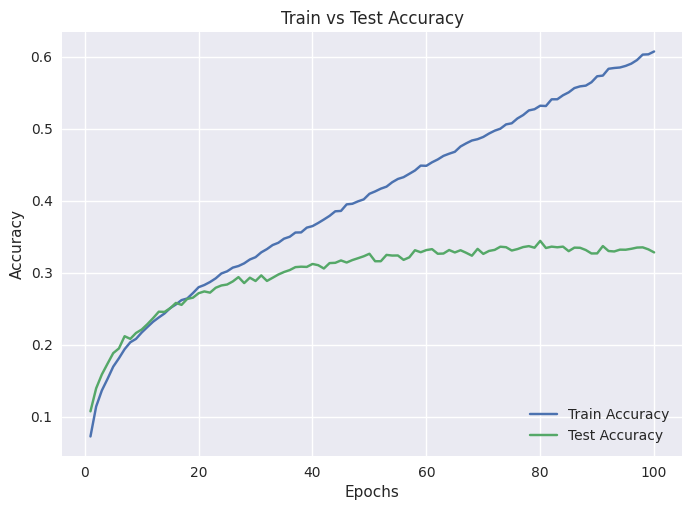

In [13]:
plt.style.use("seaborn")
train_accs_data = [acc.cpu().item() for acc in train_accs]
test_accs_data = [acc.cpu().item() for acc in test_accs]
plt.plot(range(1, 101), train_accs_data, label="Train Accuracy")
plt.plot(range(1, 101), test_accs_data, label="Test Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc="lower right")

In [14]:
pred_labels ,true_labels = test(model, test_dataloader)
true_labels = [label.cpu().item() for label in true_labels]
pred_labels = [label.cpu().item() for label in pred_labels]

100%|██████████| 313/313 [00:02<00:00, 109.42it/s]


####  Superclass confusion matrix

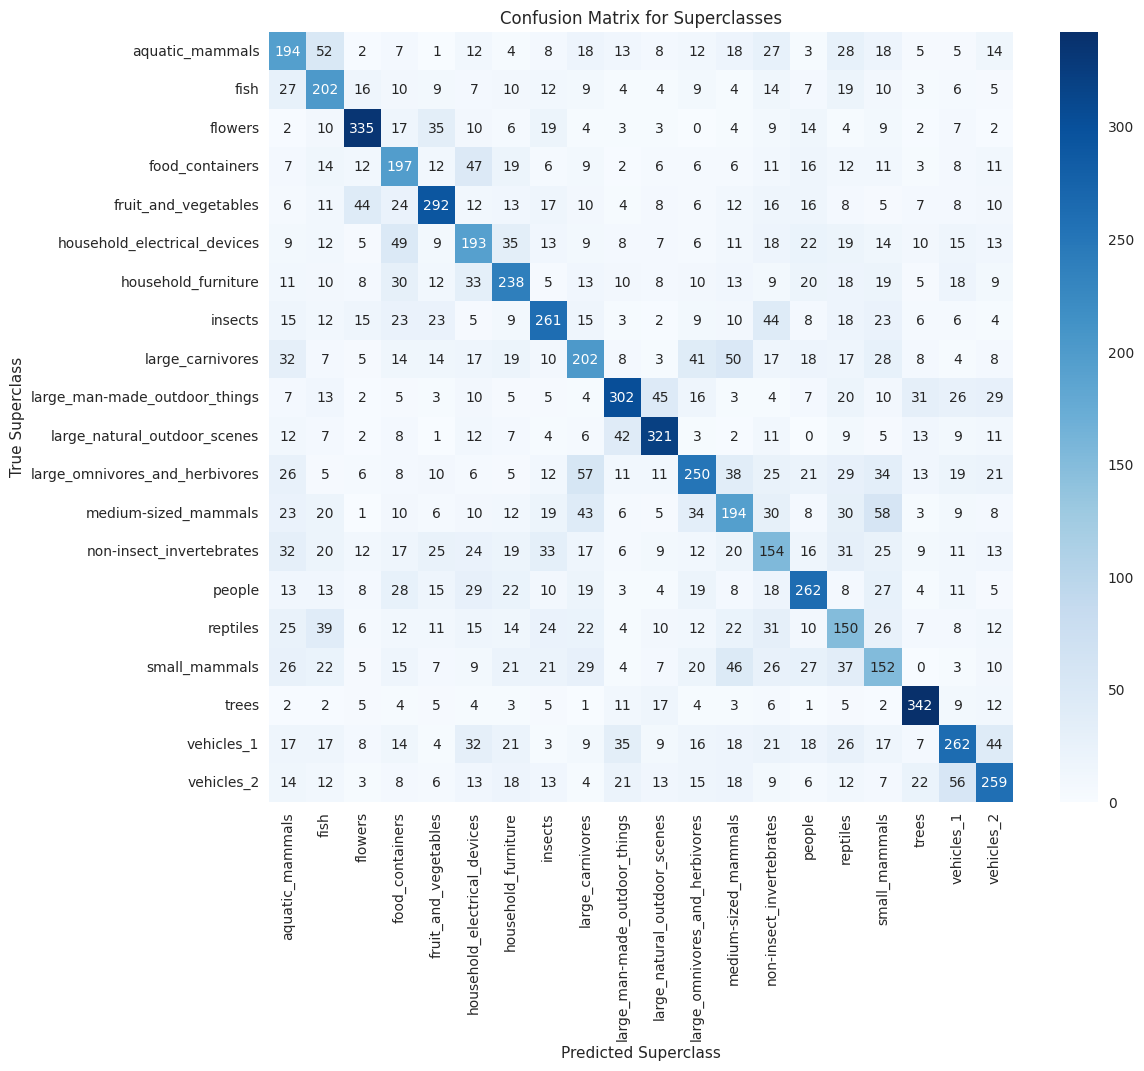

In [15]:
# Confusion matrix for superclass

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)


cm_superclass = confusion_matrix(pred_superclass_labels, true_superclass_labels)

# Vẽ confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_superclass, annot=True, xticklabels=superclass_to_classes.keys(), yticklabels=superclass_to_classes.keys(), cmap="Blues", fmt="d")
plt.xlabel("Predicted Superclass")
plt.ylabel("True Superclass")
plt.title("Confusion Matrix for CIFAR-100 Classification")
plt.title("Confusion Matrix for Superclasses")
plt.show()

####  Childclass confusion matrix

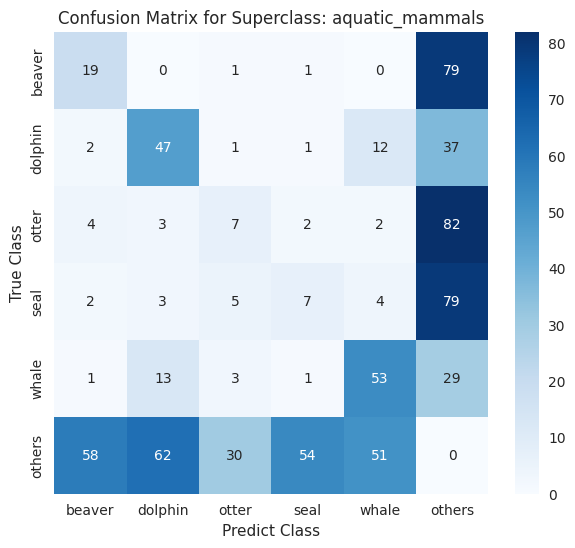

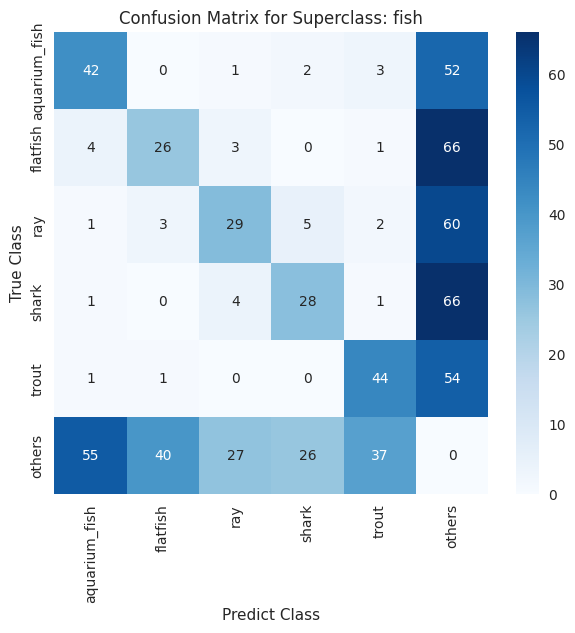

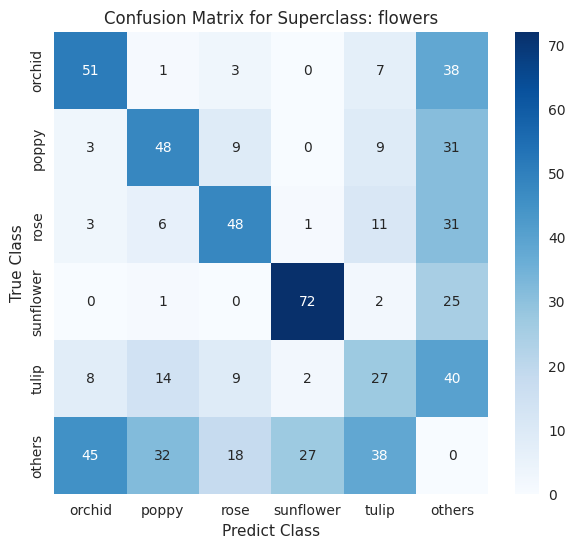

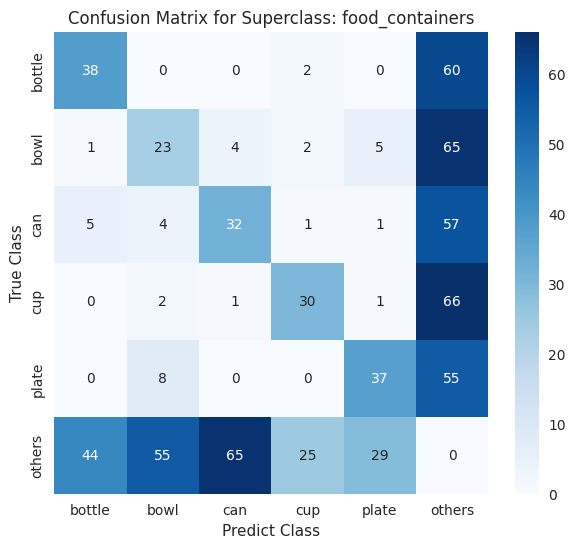

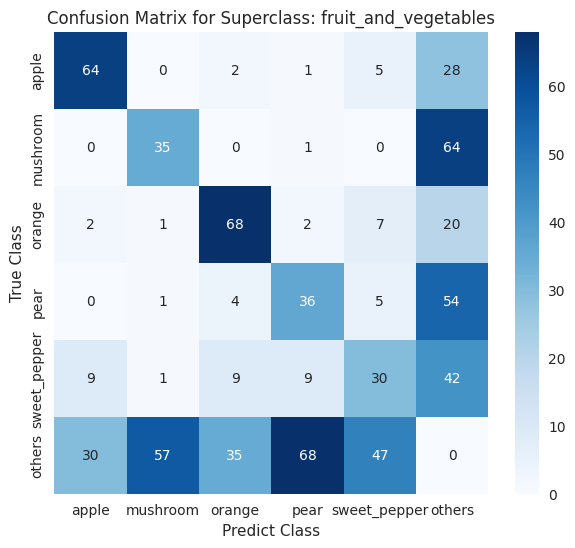

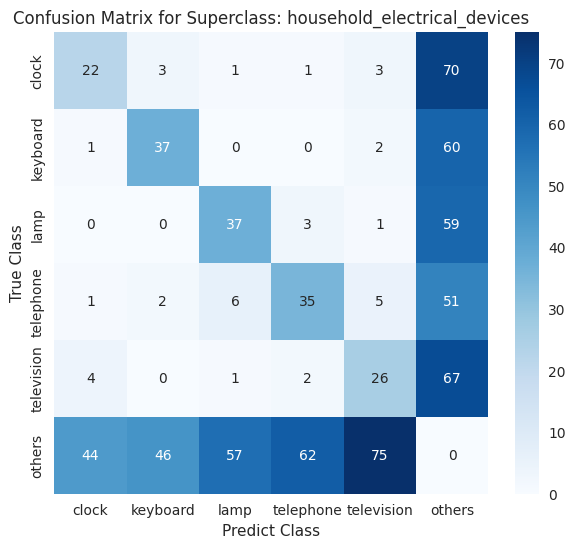

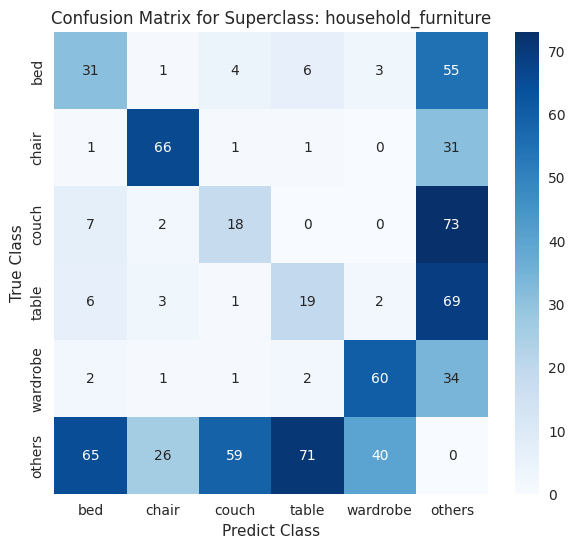

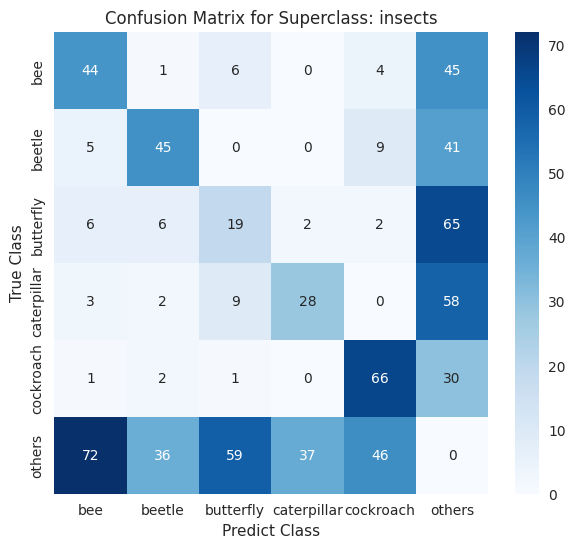

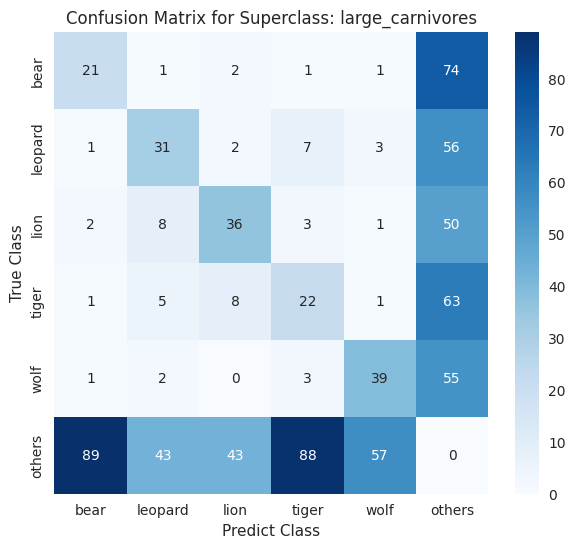

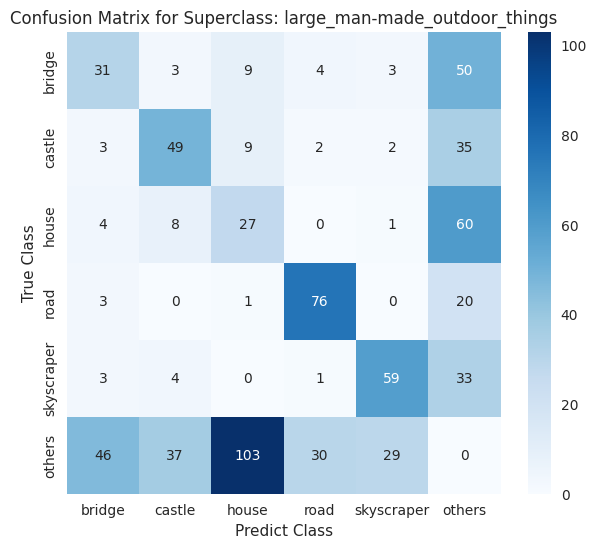

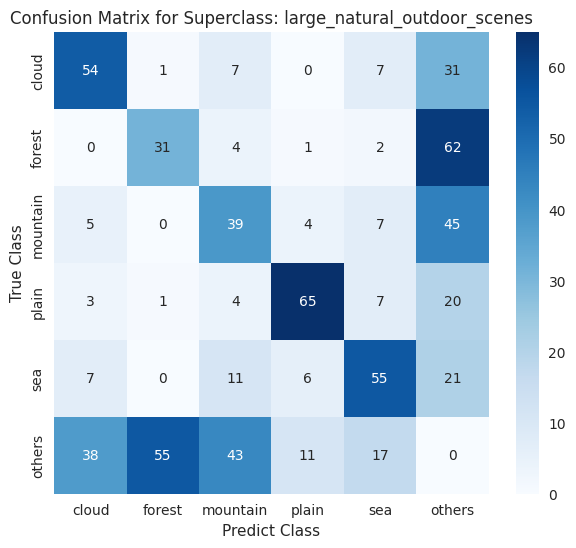

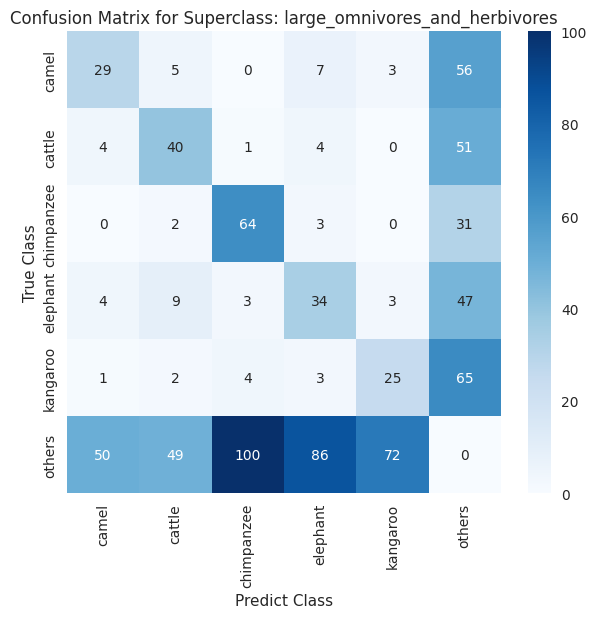

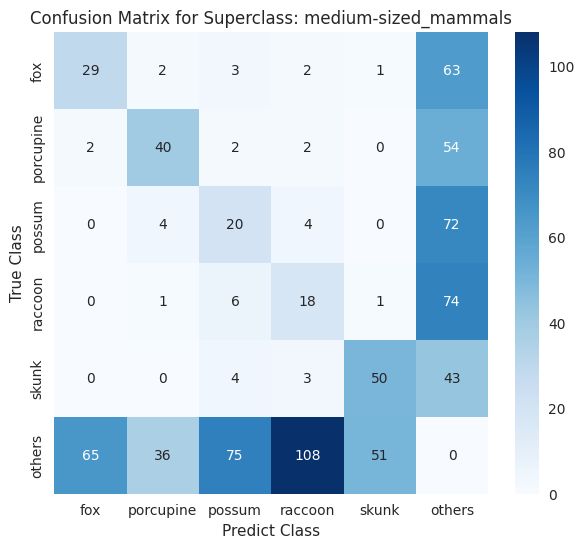

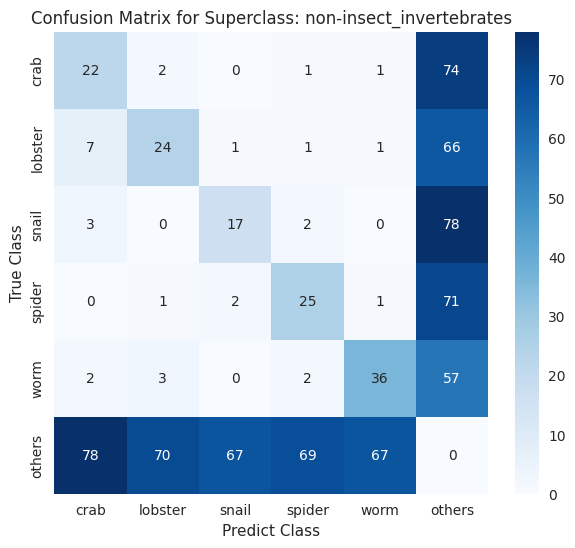

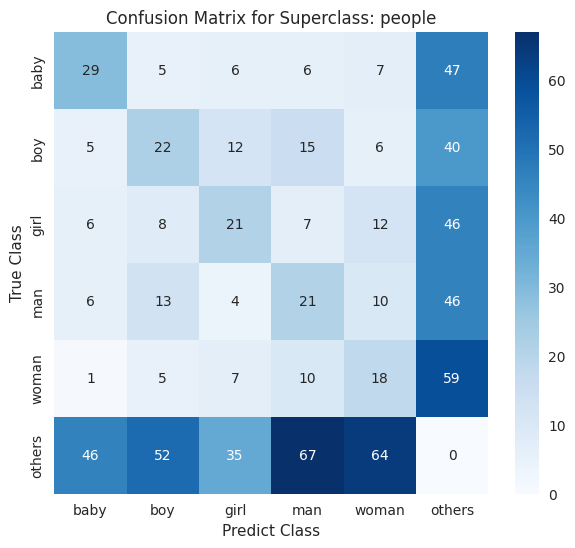

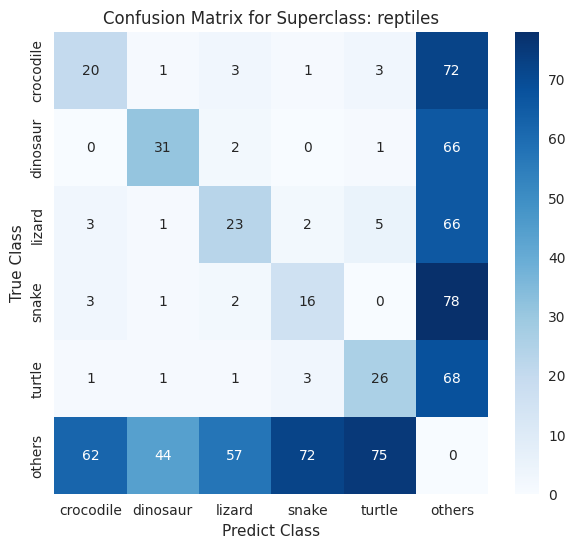

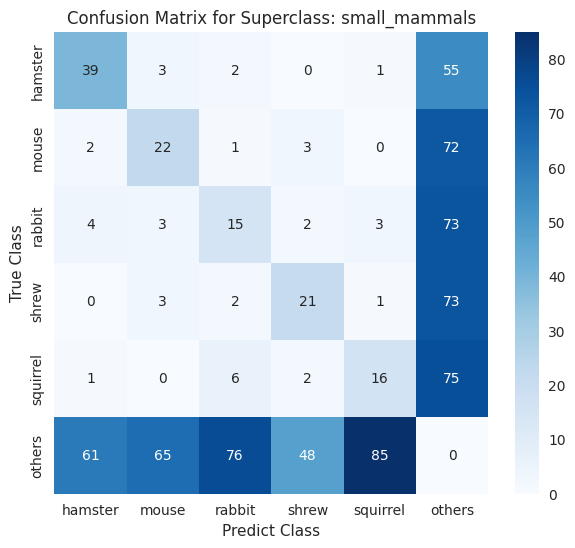

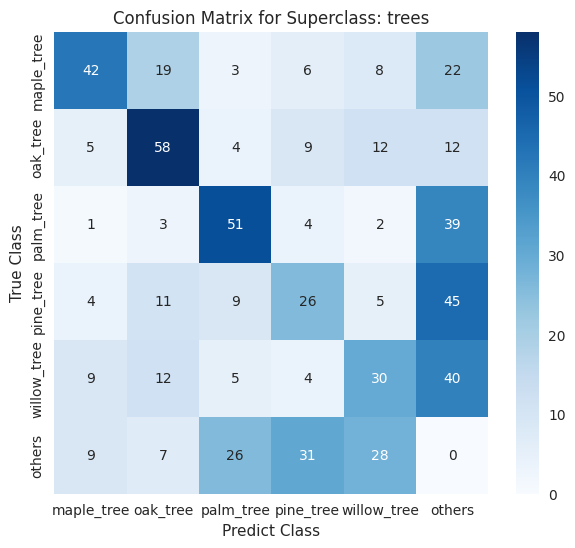

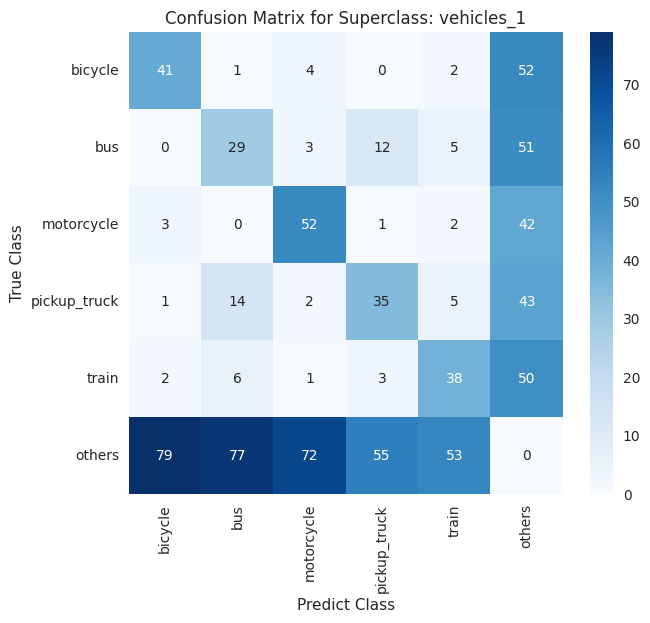

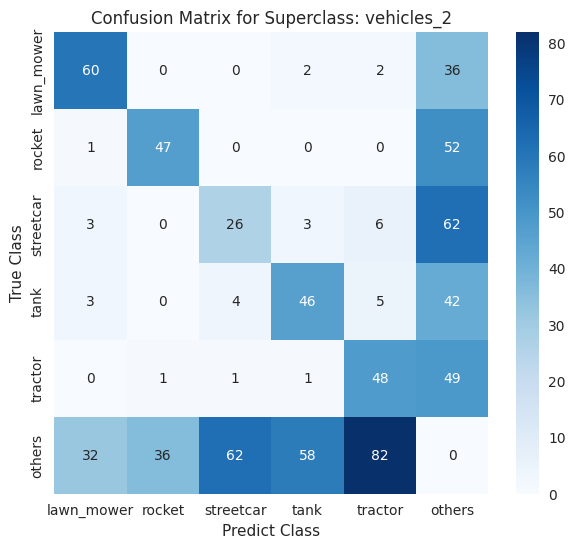

In [16]:
# Confusion matrix for superclass
true_class_labels = list_class_label(true_labels)
pred_class_labels = list_class_label(pred_labels)

superclass = {
    'aquatic_mammals': { 'true_label': [], 'pred_label': [] },
    'fish': { 'true_label': [], 'pred_label': [] },
    'flowers': { 'true_label': [], 'pred_label': [] },
    'food_containers': { 'true_label': [], 'pred_label': [] },
    'fruit_and_vegetables': { 'true_label': [], 'pred_label': [] },
    'household_electrical_devices': { 'true_label': [], 'pred_label': [] },
    'household_furniture': { 'true_label': [], 'pred_label': [] },
    'insects': { 'true_label': [], 'pred_label': [] },
    'large_carnivores': { 'true_label': [], 'pred_label': [] },
    'large_man-made_outdoor_things': { 'true_label': [], 'pred_label': [] },
    'large_natural_outdoor_scenes': { 'true_label': [], 'pred_label': [] },
    'large_omnivores_and_herbivores': { 'true_label': [], 'pred_label': [] },
    'medium-sized_mammals': { 'true_label': [], 'pred_label': [] },
    'non-insect_invertebrates': { 'true_label': [], 'pred_label': [] },
    'people': { 'true_label': [], 'pred_label': [] },
    'reptiles': { 'true_label': [], 'pred_label': [] },
    'small_mammals': { 'true_label': [], 'pred_label': [] },
    'trees': { 'true_label': [], 'pred_label': [] },
    'vehicles_1': { 'true_label': [], 'pred_label': [] },
    'vehicles_2': { 'true_label': [], 'pred_label': [] },
}

child_class = test_dataloader.dataset.classes

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)

for true_label, pred_label in zip(true_class_labels, pred_class_labels):
    true_label_superclass = get_super_by_child(true_label)
    pred_label_superclass = get_super_by_child(pred_label)
    if true_label_superclass == pred_label_superclass:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append(pred_label)
    else:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append('others')
        superclass[f'{pred_label_superclass}']['true_label'].append('others')
        superclass[f'{pred_label_superclass}']['pred_label'].append(pred_label)

colors = [
    "Blues", "BuGn", "BuPu", "GnBu", "OrRd", "PuBu", "PuRd", "RdPu", 
    "YlGn", "YlGnBu", "YlOrBr", "YlOrRd", "Oranges", "Purples", "Greens", 
    "Reds", "coolwarm", "cividis", "magma", "viridis"
]

for super_class, class_label in superclass.items():
    classes = superclass_to_classes[super_class] + ['others']
    cm_class = confusion_matrix(class_label['true_label'], class_label['pred_label'], labels=classes)
    # Vẽ confusion matrix
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_class, annot=True, xticklabels=classes, yticklabels=classes, cmap="Blues", fmt="d")
    plt.xlabel("Predict Class")
    plt.ylabel("True Class")
    plt.title(f"Confusion Matrix for Superclass: {super_class}")
    plt.show()

## **LOAD MODEL AGAIN** 

In [17]:
# # Load previous checkpoint and assign to initial variables
# checkpoint = torch.load("/kaggle/input/vit_v6/pytorch/default/1/VisionTransformer_CIFAR100_checkpoint.pt")
# last_epoch = checkpoint["epoch"]
# model = checkpoint["model"].to(device)
# optimizer = checkpoint["optimizer"]
# scheduler = checkpoint["scheduler"]
# train_accs = checkpoint["train_acc"]
# test_accs = checkpoint["test_acc"]

In [18]:
from calflops import calculate_flops
input_shape = (batch_size, channels, image_sz, image_sz)
flops, macs, params = calculate_flops(model=model, 
                                      input_shape=input_shape,
                                      output_as_string=True,
                                      output_precision=4)
print("FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  24.65 M 
fwd MACs:                                                               3.8709 GMACs
fwd FLOPs:                                                              7.7526 GFLOPS
fwd+bwd MACs:                                                           11.6126 GMACs
fwd+bwd FLOPs:                                                          23.2579 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each modu